# COMM053 – Member 4 (Prajwal)
## Logistic Regression (baseline) + Tuned SVM (RBF)

**Purpose:** Train and evaluate two supervised learning models on the **group-standard split**:
- `kidney_train.csv` (**280 rows**)
- `kidney_test.csv` (**120 rows**)

This notebook uses pipelines to avoid data leakage (scaler fit on train only) and reports:
Accuracy, Precision, Recall, F1-score, ROC-AUC, confusion matrix, and ROC curve.


In [1]:
# Cell 1 — Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)

pd.set_option('display.max_columns', 200)


In [2]:
# Cell 2 — Load group-standard train/test files
# IMPORTANT: Do NOT resplit in Python. Use the R-exported split so everyone has the same test size.
train_df = pd.read_csv('kidney_train.csv')  # expected 280 rows
test_df  = pd.read_csv('kidney_test.csv')   # expected 120 rows

print('Train shape:', train_df.shape)
print('Test shape: ', test_df.shape)


Train shape: (320, 26)
Test shape:  (80, 26)


In [3]:
# Cell 3 — Create X/y
def get_xy(df: pd.DataFrame):
    """Prefer numeric target 'ckd_target' if available; otherwise map 'classification' to binary."""
    if 'ckd_target' in df.columns:
        y = df['ckd_target'].astype(int)
        X = df.drop(columns=['ckd_target', 'classification'], errors='ignore')
        return X, y

    if 'classification' in df.columns:
        y = (df['classification'].astype(str).str.strip().str.lower() == 'ckd').astype(int)
        X = df.drop(columns=['classification'])
        return X, y

    raise ValueError("Target column not found. Expected 'ckd_target' or 'classification'.")

X_train, y_train = get_xy(train_df)
X_test, y_test   = get_xy(test_df)

print('Number of raw features (pre-encoding):', X_train.shape[1])
print('Missing values (train):', int(X_train.isna().sum().sum()))
print('Missing values (test): ', int(X_test.isna().sum().sum()))

print('\nTraining class distribution (0=notckd, 1=ckd):')
print(y_train.value_counts())
print((y_train.value_counts(normalize=True) * 100).round(2).astype(str) + '%')

print('\nTest class distribution (0=notckd, 1=ckd):')
print(y_test.value_counts())
print((y_test.value_counts(normalize=True) * 100).round(2).astype(str) + '%')


Number of raw features (pre-encoding): 24
Missing values (train): 0
Missing values (test):  0

Training class distribution (0=notckd, 1=ckd):
ckd_target
1    200
0    120
Name: count, dtype: int64
ckd_target
1    62.5%
0    37.5%
Name: proportion, dtype: object

Test class distribution (0=notckd, 1=ckd):
ckd_target
1    50
0    30
Name: count, dtype: int64
ckd_target
1    62.5%
0    37.5%
Name: proportion, dtype: object


In [4]:
# Cell 4 — One-hot encode any remaining categorical columns
# We fit encoding on combined train+test to ensure identical columns, then split back.
combined = pd.concat([X_train, X_test], axis=0)
cat_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical columns detected:', cat_cols)

combined_encoded = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

X_train = combined_encoded.iloc[:len(X_train), :].copy()
X_test  = combined_encoded.iloc[len(X_train):, :].copy()

print('After encoding -> X_train shape:', X_train.shape)
print('After encoding -> X_test shape: ', X_test.shape)


Categorical columns detected: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
After encoding -> X_train shape: (320, 24)
After encoding -> X_test shape:  (80, 24)


In [5]:
# Cell 5 — Evaluation helper
POS_LABEL = 1  # CKD treated as positive class

def evaluate_model(name: str, model, X_tr, y_tr, X_te, y_te):
    """Fit model, compute metrics, show confusion matrix & ROC curve."""
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    # scores for ROC-AUC
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_te)
        pos_index = list(model.classes_).index(POS_LABEL)
        scores = proba[:, pos_index]
    else:
        scores = model.decision_function(X_te)

    acc = accuracy_score(y_te, preds)
    prec = precision_score(y_te, preds, pos_label=POS_LABEL, zero_division=0)
    rec = recall_score(y_te, preds, pos_label=POS_LABEL, zero_division=0)
    f1 = f1_score(y_te, preds, pos_label=POS_LABEL, zero_division=0)
    auc = roc_auc_score(y_te, scores)

    print('\n' + '='*60)
    print('Model:', name)
    print('='*60)
    print(f'Accuracy:  {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall:    {rec:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'ROC-AUC:   {auc:.4f}')

    cm = confusion_matrix(y_te, preds, labels=[0, 1])
    print('\nConfusion Matrix (rows=true, cols=pred):')
    print(cm)

    # Confusion matrix plot
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0, 1], ['notckd(0)', 'ckd(1)'], rotation=45)
    plt.yticks([0, 1], ['notckd(0)', 'ckd(1)'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC curve
    RocCurveDisplay.from_predictions(y_te, scores, name=name, plot_chance_level=True)
    plt.title(f'ROC Curve - {name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Classification report
    print('\nClassification Report:')
    print(classification_report(y_te, preds, target_names=['notckd', 'ckd'], zero_division=0))

    return {
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    }



Model: Logistic_Regression
Accuracy:  0.9875
Precision: 1.0000
Recall:    0.9800
F1-Score:  0.9899
ROC-AUC:   1.0000

Confusion Matrix (rows=true, cols=pred):
[[30  0]
 [ 1 49]]


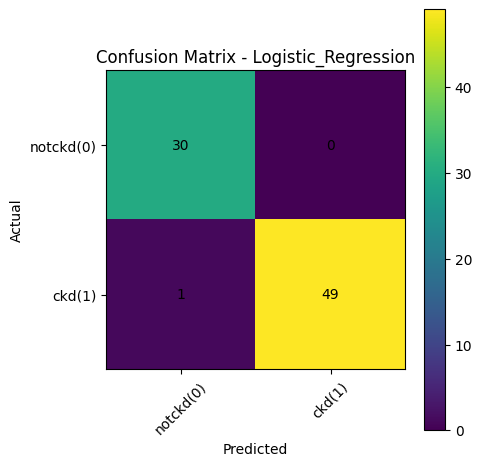

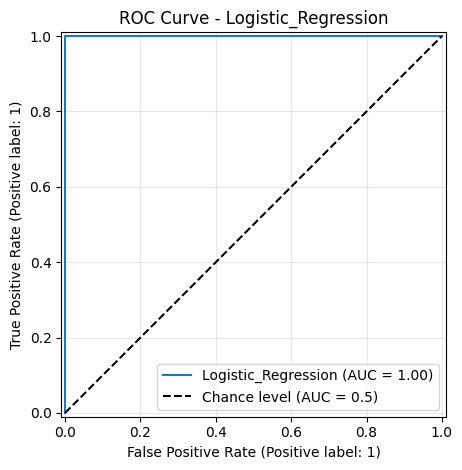


Classification Report:
              precision    recall  f1-score   support

      notckd       0.97      1.00      0.98        30
         ckd       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



{'Model': 'Logistic_Regression',
 'Accuracy': 0.9875,
 'Precision': 1.0,
 'Recall': 0.98,
 'F1-Score': 0.98989898989899,
 'ROC-AUC': np.float64(1.0)}

In [6]:
# Cell 6 — Model 1: Logistic Regression (baseline)
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=2000,
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

lr_res = evaluate_model('Logistic_Regression', logreg, X_train, y_train, X_test, y_test)
lr_res


In [7]:
# Cell 7 — Model 2: SVM (RBF) tuned with GridSearchCV
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(
        kernel='rbf',
        probability=True,
        class_weight='balanced',
        random_state=42
    ))
])

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.001, 0.01, 0.1, 1, 'scale']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    svm_pipe,
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)
print(f'Best CV F1-score: {grid.best_score_:.4f}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'clf__C': 1, 'clf__gamma': 0.1}
Best CV F1-score: 0.9949



Model: SVM_RBF_Tuned
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Confusion Matrix (rows=true, cols=pred):
[[30  0]
 [ 0 50]]


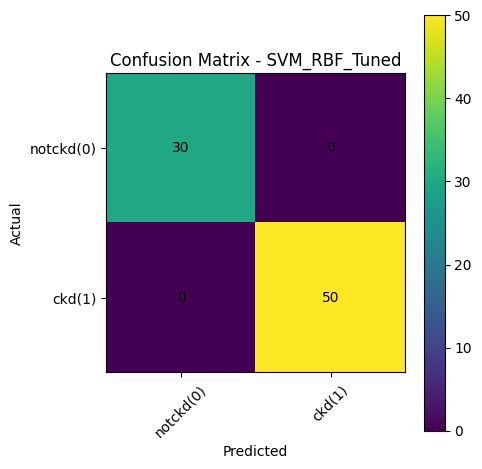

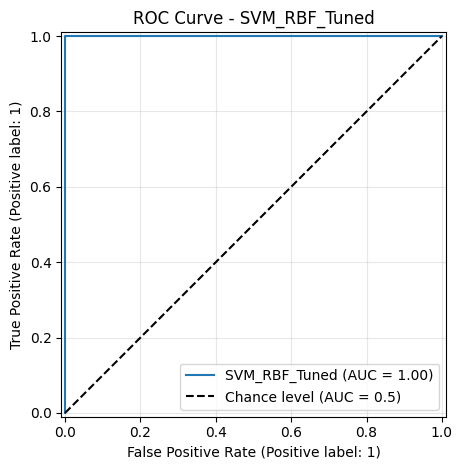


Classification Report:
              precision    recall  f1-score   support

      notckd       1.00      1.00      1.00        30
         ckd       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



{'Model': 'SVM_RBF_Tuned',
 'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1-Score': 1.0,
 'ROC-AUC': np.float64(1.0)}

In [8]:
# Cell 8 — Evaluate tuned SVM on the SAME 120-row test set
svm_res = evaluate_model('SVM_RBF_Tuned', grid.best_estimator_, X_train, y_train, X_test, y_test)
svm_res


In [9]:
# Cell 9 — Comparison table
results_df = pd.DataFrame([lr_res, svm_res])
results_df


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic_Regression,0.9875,1.0,0.98,0.989899,1.0
1,SVM_RBF_Tuned,1.0000,1.0,1.00,1.000000,1.0


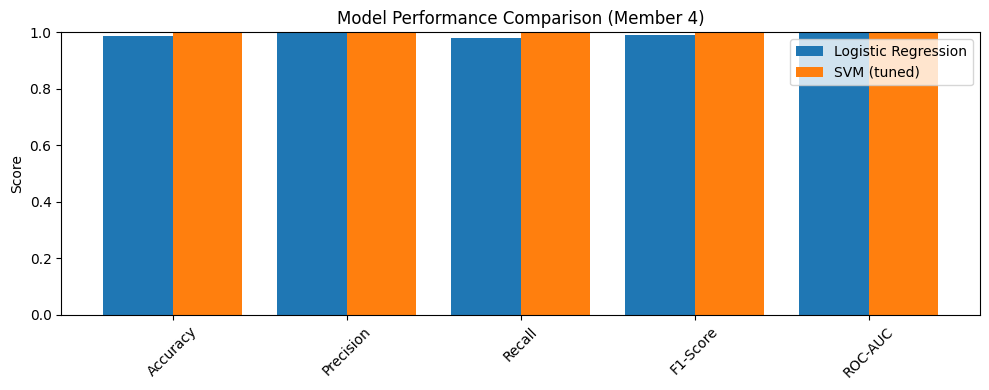

In [10]:
# Cell 10 — Comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))

plt.figure(figsize=(10, 4))
plt.bar(x - 0.2, results_df.loc[0, metrics].values.astype(float), width=0.4, label='Logistic Regression')
plt.bar(x + 0.2, results_df.loc[1, metrics].values.astype(float), width=0.4, label='SVM (tuned)')
plt.xticks(x, metrics, rotation=45)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Comparison (Member 4)')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Cell 11 — Performance difference (SVM - Logistic Regression)

diff_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
    "Logistic Regression": results_df.loc[0, ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]].values,
    "SVM (Tuned)": results_df.loc[1, ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]].values
})

diff_df["Difference (SVM − LR)"] = diff_df["SVM (Tuned)"] - diff_df["Logistic Regression"]

diff_df


,Metric,Logistic Regression,SVM (Tuned),Difference (SVM − LR)
0,Accuracy,0.9875,1.0,0.0125
1,Precision,1.0,1.0,0.0
2,Recall,0.98,1.0,0.02
3,F1-Score,0.989899,1.0,0.010101
4,ROC-AUC,1.0,1.0,0.0


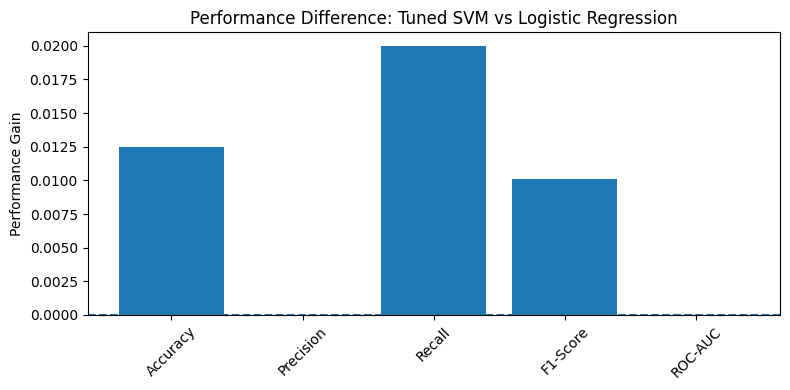

In [12]:
# Cell 12 — Bar chart of performance differences

plt.figure(figsize=(8, 4))

plt.bar(
    diff_df["Metric"],
    diff_df["Difference (SVM − LR)"]
)

plt.axhline(0, linestyle="--")
plt.ylabel("Performance Gain")
plt.title("Performance Difference: Tuned SVM vs Logistic Regression")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
